In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import os

documents = [pd.read_csv("training_data/"+doc) for doc in os.listdir("training_data")]
all_vectors = pd.concat(documents)
documents[0].head()

,words_num,awerage_word_length,italicness,formuleness,heading_first_word,boldness_first_word,is_capital_first_letter,type
0,1,1.0,0.0,0.0,False,0.0,False,text
1,1,1.0,0.0,0.0,False,0.0,False,text
2,1,1.0,0.0,0.0,False,0.0,False,text
3,1,1.0,0.0,0.0,False,0.0,False,text
4,2,0.0,0.0,0.0,False,0.0,False,text


In [2]:
# Place features in X and types in Y


def get_features(vectors):
    return vectors.drop('type', axis=1)

def get_types(vectors):
    return vectors['type']

def pd_to_dict_list(data):
    return data.to_dict('records')
    #return data.values.tolist()

def pd_type_column_to_string_list(data):
     return [ x for x in data ]

X_pd = get_features(all_vectors)
y_pd = get_types(all_vectors)

X_doc_list = [ pd_to_dict_list(get_features(doc)) for doc in documents ]
y_doc_list = [ pd_type_column_to_string_list(get_types(doc)) for doc in documents ]


y_doc_list[0][52:56], X_doc_list[0][52]

(['text', 'text', 'text', 'text'],
 {'awerage_word_length': 20.0,
  'boldness_first_word': 0.0,
  'formuleness': 0.0,
  'heading_first_word': False,
  'is_capital_first_letter': False,
  'italicness': 0.0,
  'words_num': 1})

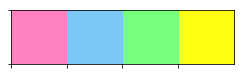

In [6]:
# Plot palette
col_list = ["pink", "lightblue", "lightgreen", "yellow"]
sns.palplot(sns.xkcd_palette(col_list))

In [ ]:
# Plot
col_list_palette = sns.xkcd_palette(col_list)
sns.set_palette(col_list_palette)
sns.set_context("paper", rc={"axes.labelsize":45})
plot=sns.pairplot(
    data=lines_vectors, hue="type",
    plot_kws = {'alpha': 0.3, 'edgecolor': 'k'},
    markers = ["+", "o", "s", "D"],
    height=10)
plot._legend.get_title().set_fontsize(45)
plot

In [8]:
# Save plot
plot.savefig("plots/lines_plot_23.png")

In [3]:
# Separating data to training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pd, y_pd, test_size=0.3)

In [11]:
# Trying Naive Bayes Classification on lines
from sklearn.naive_bayes import GaussianNB # 1. choose model class
model = GaussianNB()                       # 2. instantiate model
model.fit(X_train, y_train)                  # 3. fit model to data
y_model = model.predict(X_test)             # 4. predict on new data
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_model)

0.82710799403382951

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_doc_list, y_doc_list, test_size=0.3)

import pycrfsuite
trainer = pycrfsuite.Trainer(verbose=True)

#TODO: debug!!!

# Submit training data to the trainer
for xseq, yseq in zip(X_train, y_train):
    trainer.append(xseq, yseq)

# Set the parameters of the model
trainer.set_params({
    # coefficient for L1 penalty
    'c1': 0.18,

    'c2': 0.01,  

    # maximum number of iterations
    'max_iterations': 100,

    # whether to include transitions that
    # are possible, but not observed
    'feature.possible_transitions': True
})

# Save the model to the file
trainer.train('crf.model')

Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 44
Seconds required: 0.024

L-BFGS optimization
c1: 0.100000
c2: 0.010000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

***** Iteration #1 *****
Loss: 81385.243786
Feature norm: 0.500000
Error norm: 133424.198740
Active features: 44
Line search trials: 2
Line search step: 0.000001
Seconds required for this iteration: 0.090

***** Iteration #2 *****
Loss: 69313.120068
Feature norm: 0.447666
Error norm: 123281.398374
Active features: 39
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.033

***** Iteration #3 *****
Loss: 51685.477864
Feature norm: 0.414953
Error norm: 40797.141502
Active features: 38
Line search trials: 4
Line search step: 0.125000
Seconds required for this iter

***** Iteration #44 *****
Loss: 4211.344140
Feature norm: 17.086487
Error norm: 84005.869887
Active features: 44
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.033

***** Iteration #45 *****
Loss: 4161.624668
Feature norm: 17.448711
Error norm: 134427.970754
Active features: 44
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.031

***** Iteration #46 *****
Loss: 4015.407297
Feature norm: 17.782492
Error norm: 11930.893561
Active features: 43
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.033

***** Iteration #47 *****
Loss: 3838.239087
Feature norm: 18.780731
Error norm: 5620.315725
Active features: 42
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.033

***** Iteration #48 *****
Loss: 3791.983206
Feature norm: 22.664488
Error norm: 188142.845696
Active features: 43
Line search trials: 2
Line search step: 0.500000
Seconds requi

***** Iteration #93 *****
Loss: 2893.074453
Feature norm: 22.925336
Error norm: 29708.499006
Active features: 44
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.031

***** Iteration #94 *****
Loss: 2880.173253
Feature norm: 22.977399
Error norm: 16150.285848
Active features: 44
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.031

***** Iteration #95 *****
Loss: 2868.417231
Feature norm: 22.988667
Error norm: 16532.658623
Active features: 44
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.031

***** Iteration #96 *****
Loss: 2862.653206
Feature norm: 22.980465
Error norm: 12740.057030
Active features: 44
Line search trials: 1
Line search step: 1.000000
Seconds required for this iteration: 0.031

***** Iteration #97 *****
Loss: 2857.978969
Feature norm: 23.003232
Error norm: 10064.767439
Active features: 44
Line search trials: 1
Line search step: 1.000000
Seconds requir

In [24]:
# Trying Conditional Randomf Fields
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.metrics import make_scorer
from sklearn.grid_search import RandomizedSearchCV
import scipy.stats

#TODO: debug!!!

# Separating data to training and test
X_train, X_test, y_train, y_test = train_test_split(X_doc_list, y_doc_list, test_size=0.3)

# Set the parameters of the model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
        
    c1 = 0.18,
    c2 = 0.017,
    
    max_iterations=100,
    
    # whether to include transitions that
    # are possible, but not observed
    all_possible_transitions=True
)

crf.fit(X_train, y_train)
y_pred = crf.predict(X_train)

print(metrics.flat_classification_report(y_train, y_pred, digits=12))

              precision    recall  f1-score   support

  after_body  1.000000000000 0.009009009009 0.017857142857       333
        body  0.105263157895 0.000201938611 0.000403103900      9904
     heading  1.000000000000 0.021052631579 0.041237113402       380
        text  0.855294583271 0.999744759595 0.921895571459     62686

 avg / total  0.755365026843 0.855121891328 0.788720170596     73303



In [16]:

#rs.fit(X_train, y_train)

#crf=rs.best_estimator_
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

labels = ['heading', 'body', 'after_body']

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space,
                        cv=3,
                        verbose=1,
                        n_jobs=-1,
                        n_iter=50,
                        scoring=f1_scorer)

In [13]:

rs.best_params_
#rs.best_score_

{'c1': 0.18345021511589954, 'c2': 0.017602474295444183}

In [8]:
from collections import Counter

def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])


Top positive:
2.983642 heading  boldness_first_word
1.928631 after_body is_capital_first_letter
1.398146 heading  heading_first_word
1.226730 heading  italicness
1.118345 heading  is_capital_first_letter
0.369002 body     formuleness
0.182292 text     formuleness
0.088482 body     italicness
0.017015 text     italicness
-0.006936 body     awerage_word_length
-0.017751 text     awerage_word_length
-0.040674 after_body words_num
-0.042550 body     words_num
-0.046238 text     words_num
-0.050263 text     is_capital_first_letter
-0.061316 body     is_capital_first_letter
-0.072051 heading  words_num
-0.103934 after_body awerage_word_length
-0.105542 body     boldness_first_word
-0.133899 after_body boldness_first_word
-0.162554 text     heading_first_word
-0.307814 text     boldness_first_word
-0.372976 heading  awerage_word_length
-0.442265 after_body italicness
-1.153415 body     heading_first_word
-1.863615 after_body heading_first_word
-2.280476 heading  formuleness
-2.699251 after_bo

Dark blue => 0.0, dark red => 0.02748


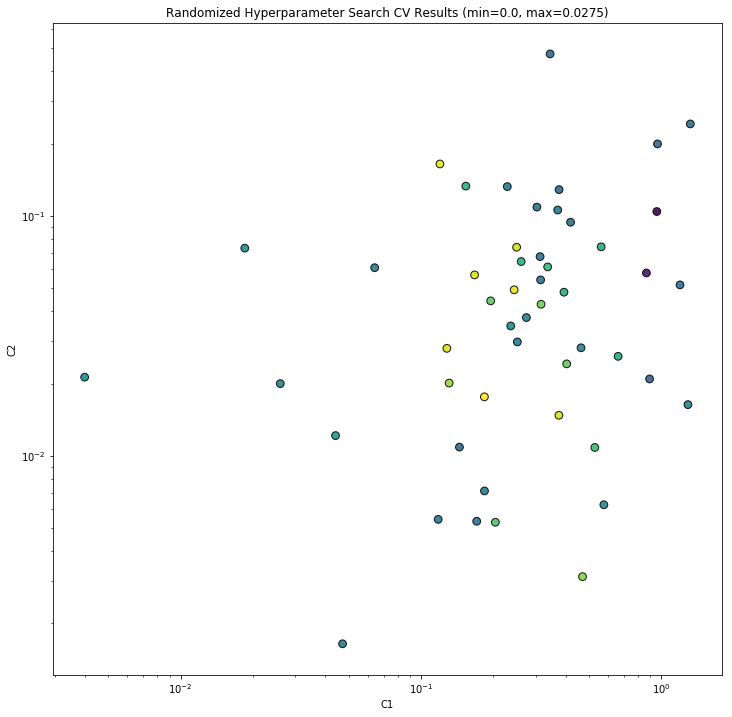

In [6]:
import matplotlib.pyplot as plt

_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [10]:

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
text   -> text    2.278445
body   -> body    2.092267
body   -> after_body 0.364124
heading -> body    0.209091
after_body -> text    -0.072047
text   -> heading -0.181744
after_body -> heading -0.281000
heading -> after_body -1.287640
body   -> heading -1.941457
heading -> heading -2.764509
after_body -> after_body -5.054711
after_body -> body    -5.484160
text   -> after_body -7.461776
heading -> text    -8.421398
body   -> text    -8.664555
text   -> body    -9.023770

Top unlikely transitions:
text   -> text    2.278445
body   -> body    2.092267
body   -> after_body 0.364124
heading -> body    0.209091
after_body -> text    -0.072047
text   -> heading -0.181744
after_body -> heading -0.281000
heading -> after_body -1.287640
body   -> heading -1.941457
heading -> heading -2.764509
after_body -> after_body -5.054711
after_body -> body    -5.484160
text   -> after_body -7.461776
heading -> text    -8.421398
body   -> text    -8.664555
text   -> body    -9.0237

In [28]:
len(y_train), len(y_test)

(61, 27)